In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
def sample_dataset(input_dataset, n):
    """
    Randomly sample a dataset of size n x k from the given input dataset.

    Parameters:
    - input_dataset: numpy array of shape (N, k), where N is the number of samples, and k is the number of features.
    - n: The number of samples to randomly select per feature.

    Returns:
    - sampled_dataset: numpy array of shape (n, k), the sampled dataset.
    """
    N, k = input_dataset.shape

    # Check if the requested sample size is valid
    if n * k > N:
        raise ValueError("Requested sample size is larger than the input dataset.")

    # Randomly select n samples for each feature
    indices = np.random.choice(N, n, replace=False)
    sampled_dataset = input_dataset[indices, :]

    return sampled_dataset



In [ ]:
# Assume you have a dataset `original_dataset` of size N x k
original_dataset = np.random.rand(100, 5)  # Example dataset of 100 samples and 5 features

# Set the desired sample size per feature
n = 10

# Call the function to get the sampled dataset
sampled_data = sample_dataset(original_dataset, n)

# Print the original and sampled dataset shapes for verification
print("Original dataset shape:", original_dataset.shape)
print("Sampled dataset shape:", sampled_data.shape)

In [3]:
def orthonormal_space(data,n_eig_vecs):
    """
    Calculate the orthonormal space of a data matrix using SVD.

    Args:
        data (numpy.ndarray): The data matrix, of shape (n, k).
        n_eig_vecs (int): The number of eigenvectors to keep. If None, all eigenvectors will be kept.

    Returns:
        numpy.ndarray: The orthonormal space, of shape (n, n_eig_vecs).
    """

    n, k = data.shape
    u, s, v = np.linalg.svd(data)


    orthonormal_space = u[:, :n_eig_vecs] 

    return torch.tensor(orthonormal_space, dtype=torch.float32)

In [ ]:
n_eig_vecs=7
a=orthonormal_space(sampled_data,n_eig_vecs)

# Experiments on Breast Cancer dataset

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
data = load_breast_cancer()

In [ ]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [ ]:
X.shape,y.shape

In [ ]:
unique_classes, counts = np.unique(y, return_counts=True)

In [ ]:
unique_classes, counts

In [4]:
# sample from X and y 

def sample_data(X, y, num_samples=250):
    num_data = len(X)
    indices = np.random.choice(num_data, size=num_samples, replace=False)
    sampled_X = X[indices]
    sampled_y = y[indices]
    return sampled_X, sampled_y


In [ ]:
samp_X, samp_y = sample_data(X,y,num_samples=250)

In [ ]:
np.unique(samp_y,return_counts=True)

In [71]:
samp_X.shape

(850, 28)

In [ ]:
samp_y.shape

In [ ]:
n_eig_vecs=250
orth_x=orthonormal_space(X,n_eig_vecs=250)

In [ ]:
P=orth_x.T

In [ ]:
P.shape

In [ ]:
y_small=torch.tensor(samp_y, dtype=torch.float32).view(-1, 1)

In [ ]:
y_small.shape

In [ ]:
y=torch.tensor(y, dtype=torch.float32).view(-1,1)
y.shape

In [14]:

def sample_vector(M):
    """
    Samples a random vector from the space spanned by the columns of the orthonormal matrix M.
    """
    # Generate a random vector of coefficients
    coeffs = np.random.randn(M.shape[1])
    # Sample a vector from the space spanned by M
    vector = M @ coeffs
    return vector

# Example usage:
vector_sample= sample_vector(orth_x)


# Probabilistic method 

In [20]:
# probabilistic sampling method

from torch.distributions import Normal, kl_divergence

class VariationalLinearModel(nn.Module):
    def __init__(self, n,N):
        super(VariationalLinearModel, self).__init__()
        self.alpha_mu = nn.Parameter(torch.randn(N, 1))  # Mean of alpha
        self.alpha_logvar = nn.Parameter(torch.randn(N, 1))  # Log variance of alpha
        self.b = nn.Parameter(torch.randn(n,1 )) 

    def forward(self, P):
        
        alpha_std = torch.exp(0.5 * self.alpha_logvar)
        alpha = self.alpha_mu + alpha_std * torch.randn_like(alpha_std)
        return torch.matmul(P, alpha) + self.b


def kl_divergence_loss(p, q):
    return kl_divergence(p, q).sum()

def train_model(P, y,  model, learning_rate=0.01, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
    predicted_y_list = []
    loss_list=[]
    
    for epoch in range(epochs):
        model.train()  
        optimizer.zero_grad()  
        
        outputs = model(P)  # Predictions for y (full dataset) of shape (250,1)
        
        outputs_dist = Normal(outputs.mean(), outputs.std())
        y_dist = Normal(y.mean(), y.std())
        kl_loss = kl_divergence_loss(outputs_dist, y_dist)
        loss_list.append(kl_loss.item())
        
        kl_loss.backward()  
        optimizer.step()  
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], KL Loss: {kl_loss.item():.4f}')
        
        predicted_y_list.append(outputs.detach().clone())  

    return  loss_list,predicted_y_list

In [ ]:
model= VariationalLinearModel(250,569)

In [ ]:
loss_list,_=train_model(P, y, model, learning_rate=0.01, epochs= 1000 )

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(loss_list, label='KL Divergence Loss')
plt.title('KL Divergence Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
class Re_VAE_LinearModel(nn.Module):
    def __init__(self, n,N):
        super(Re_VAE_LinearModel, self).__init__()
        self.beta_mu = nn.Parameter(torch.randn(n, 1))  # Mean of beta
        self.beta_logvar = nn.Parameter(torch.randn(n, 1))  # Log variance of beta
        self.b = nn.Parameter(torch.randn(N,1 )) 

    def forward(self, P):
        
        beta_std = torch.exp(0.5 * self.beta_logvar)
        beta = self.beta_mu + beta_std * torch.randn_like(beta_std)
        return torch.matmul(P.T, beta) - self.b


In [ ]:
model2=Re_VAE_LinearModel(250,569)

In [ ]:
loss_list_2,_=train_model(P, y, model2, learning_rate=0.01, epochs= 1000 )

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(loss_list_2, label='KL Divergence Loss')
plt.title('KL Divergence Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
len (loss_list_2)

In [ ]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(loss_list, label='KL Divergence Loss_(smaller space)')
ax1.plot(loss_list_2, label='KL Divergence Loss_(bigger space)')
plt.title('KL Divergence Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Runnning DL Model on EEG dataset

In [6]:
import torch
from torch import nn,optim
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.preprocessing import MinMaxScaler  
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import random_split,DataLoader,Dataset

In [7]:
df=pd.read_csv("/home/rabink1/D1/df_result_combined.csv")


In [8]:
df.columns

Index(['age', 'A_mean_corr', 'A_gev', 'A_occurrences', 'A_timecov',
       'A_meandurs', 'B_mean_corr', 'B_gev', 'B_occurrences', 'B_timecov',
       'B_meandurs', 'C_mean_corr', 'C_gev', 'C_occurrences', 'C_timecov',
       'C_meandurs', 'D_mean_corr', 'D_gev', 'D_occurrences', 'D_timecov',
       'D_meandurs', 'F_mean_corr', 'F_gev', 'F_occurrences', 'F_timecov',
       'F_meandurs', 'unlabeled', 'gfp_value', 'diagnosis'],
      dtype='object')

In [6]:
df.diagnosis.value_counts()

0    459
1    416
2    311
Name: diagnosis, dtype: int64

In [9]:
X = df.iloc[:, 0:-1]
y = df.diagnosis

In [10]:
X=X.to_numpy()
y=y.to_numpy()

In [9]:
type(X)

numpy.ndarray

In [11]:
samp_X, samp_y = sample_data(X,y,num_samples=850) 

In [12]:
samp_X.shape

(850, 28)

In [28]:
# split the dataset 

# Split into train+val and test
X_trainval, X_test, y_trainval, y_test= train_test_split(samp_X, samp_y, test_size=0.2, stratify=samp_y, random_state=69)
 
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [29]:
X_train.shape

(612, 28)

In [12]:
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_val)

In [30]:
X_train, y_train = np.expand_dims(np.array(X_train),1), np.array(y_train)
X_val, y_val = np.expand_dims(np.array(X_val),1), np.array(y_val)


In [31]:
X_val.shape

(68, 1, 28)

In [21]:
class MsDataset(Dataset):
     def __init__(self,signals,labels):
         self.signals=signals
         self.labels=labels

     def __len__(self):
        return len(self.signals)

     def __getitem__(self, idx):
        signal,label= self.signals[idx], self.labels[idx]
        return signal,label

In [32]:
train_dataset = MsDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = MsDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())

train_loader = DataLoader(dataset=train_dataset, batch_size=32)
val_loader=DataLoader(dataset=val_dataset, batch_size=32)


In [33]:
a,b=next(iter(train_loader))
a.shape, b.shape

(torch.Size([32, 1, 28]), torch.Size([32]))

In [4]:
from typing import cast, Union, List
import torch.nn.functional as F


class Conv1dSamePadding(nn.Conv1d):

    def forward(self, input):
        return conv1d_same_padding(input, self.weight, self.bias, self.stride,
                                   self.dilation, self.groups)


def conv1d_same_padding(input, weight, bias, stride, dilation, groups):
    # stride and dilation are expected to be tuples.
    kernel, dilation, stride = weight.size(2), dilation[0], stride[0]
    l_out = l_in = input.size(2)
    padding = (((l_out - 1) * stride) - l_in + (dilation * (kernel - 1)) + 1)
    if padding % 2 != 0:
        input = F.pad(input, [0, 1])

    return F.conv1d(input=input, weight=weight, bias=bias, stride=stride,
                    padding=padding // 2,
                    dilation=dilation, groups=groups)


class ConvBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int,
                 stride: int) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            Conv1dSamePadding(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=stride),
            nn.BatchNorm1d(num_features=out_channels),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore

        return self.layers(x)

In [ ]:
class InceptionModel(nn.Module):
    """
    Parameters
    ----------
    num_blocks:
        The number of inception blocks to use. One inception block consists
        of 3 convolutional layers, (optionally) a bottleneck and (optionally) a residual
        connector
    in_channels:
        The number of input channels (i.e. input.shape[-1])
    out_channels:
        The number of "hidden channels" to use. Can be a list (for each block) or an
        int, in which case the same value will be applied to each block
    bottleneck_channels:
        The number of channels to use for the bottleneck. Can be list or int. If 0, no
        bottleneck is applied
    kernel_sizes:
        The size of the kernels to use for each inception block. Within each block, each
        of the 3 convolutional layers will have kernel size
        `[kernel_size // (2 ** i) for i in range(3)]`
    num_pred_classes:
        The number of output classes
    """

    def __init__(self, num_blocks: int, in_channels: int, out_channels: Union[List[int], int],
                 bottleneck_channels: Union[List[int], int], kernel_sizes: Union[List[int], int],
                 use_residuals: Union[List[bool], bool, str] = 'default',
                 num_pred_classes: int = 1
                 ) -> None:
        super().__init__()

        # for easier saving and loading
        self.input_args = {
            'num_blocks': num_blocks,
            'in_channels': in_channels,
            'out_channels': out_channels,
            'bottleneck_channels': bottleneck_channels,
            'kernel_sizes': kernel_sizes,
            'use_residuals': use_residuals,
            'num_pred_classes': num_pred_classes
        }

        channels = [in_channels] + cast(List[int], self._expand_to_blocks(out_channels,
                                                                          num_blocks))
        bottleneck_channels = cast(List[int], self._expand_to_blocks(bottleneck_channels,
                                                                     num_blocks))
        kernel_sizes = cast(List[int], self._expand_to_blocks(kernel_sizes, num_blocks))
        if use_residuals == 'default':
            use_residuals = [True if i % 3 == 2 else False for i in range(num_blocks)]
        use_residuals = cast(List[bool], self._expand_to_blocks(
            cast(Union[bool, List[bool]], use_residuals), num_blocks)
        )

        self.blocks = nn.Sequential(*[
            InceptionBlock(in_channels=channels[i], out_channels=channels[i + 1],
                           residual=use_residuals[i], bottleneck_channels=bottleneck_channels[i],
                           kernel_size=kernel_sizes[i]) for i in range(num_blocks)
        ])

        # a global average pooling (i.e. mean of the time dimension) is why
        # in_features=channels[-1]
        self.linear = nn.Linear(in_features=channels[-1], out_features=num_pred_classes)

    @staticmethod
    def _expand_to_blocks(value: Union[int, bool, List[int], List[bool]],
                          num_blocks: int) -> Union[List[int], List[bool]]:
        if isinstance(value, list):
            assert len(value) == num_blocks, \
                f'Length of inputs lists must be the same as num blocks, ' \
                f'expected length {num_blocks}, got {len(value)}'
        else:
            value = [value] * num_blocks
        return value

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        x = self.blocks(x).mean(dim=-1)  # the mean is the global average pooling
        return self.linear(x)


class InceptionBlock(nn.Module):
    """An inception block consists of an (optional) bottleneck, followed
    by 3 conv1d layers. Optionally residual
    """

    def __init__(self, in_channels: int, out_channels: int,
                 residual: bool, stride: int = 1, bottleneck_channels: int = 32,
                 kernel_size: int = 40) -> None:
        assert kernel_size > 3, "Kernel size must be strictly greater than 3"
        super().__init__()

        self.use_bottleneck = bottleneck_channels > 0
        if self.use_bottleneck:
            self.bottleneck = Conv1dSamePadding(in_channels, bottleneck_channels,
                                                kernel_size=1, bias=False)
        kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
        start_channels = bottleneck_channels if self.use_bottleneck else in_channels
        channels = [start_channels] + [out_channels] * 3
        self.conv_layers = nn.Sequential(*[
            Conv1dSamePadding(in_channels=channels[i], out_channels=channels[i + 1],
                              kernel_size=kernel_size_s[i], stride=stride, bias=False)
            for i in range(len(kernel_size_s))
        ])
        
        self.max_pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1, return_indices=False)
        self.batchnorm = nn.BatchNorm1d(num_features=channels[-1])
        self.relu = nn.ReLU()

        self.use_residual = residual
        if residual:
            self.residual = nn.Sequential(*[
                Conv1dSamePadding(in_channels=in_channels, out_channels=out_channels,
                                  kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
                nn.ReLU()
            ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        org_x = x
        if self.use_bottleneck:
            x = self.bottleneck(x)
        x = self.conv_layers(x)

        if self.use_residual:
            x = x + self.residual(org_x)
        return x

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [8]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}


ins_model=InceptionModel(num_blocks=4, in_channels=1, out_channels=32,
                           bottleneck_channels=2, kernel_sizes=[5,7,14,21,], use_residuals=True,
                           num_pred_classes=3)

In [17]:
EPOCHS = 2000
model=ins_model
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),weight_decay=1e-5, lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.000001, max_lr=0.01)

In [30]:


def train( n_epochs, val_acc_max_input ,model, optimizer, criterion, checkpoint_path, best_model_path,start_epoch=1):
    
    
    val_acc_max = val_acc_max_input 
    for e in tqdm(range(start_epoch, n_epochs+1)):
        
        # TRAINING
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:

            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
            y_train_pred = model(X_train_batch)

            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)
            
            train_loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
            
            
        # VALIDATION    
        with torch.no_grad():
            
            val_epoch_loss = 0
            val_epoch_acc = 0
            
            model.eval()
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                
                y_val_pred = model(X_val_batch)
                            
                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = multi_acc(y_val_pred, y_val_batch)
                
                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()

        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))
        accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stats['val'].append(val_epoch_acc/len(val_loader))


        valid_accuracy= val_epoch_acc/len(val_loader)

        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


        # create checkpoint variable and add important data
        checkpoint = {
                'epoch': e + 1,
                'valid_acc_max': valid_accuracy,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

        if valid_accuracy > val_acc_max:
                print('Validation accuracy increased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_acc_max,valid_accuracy))
                # save checkpoint as best model
                save_ckp(checkpoint, True, checkpoint_path, best_model_path)
                val_acc_max = valid_accuracy
                
    return model

In [15]:

import shutil

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)


def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_acc_max = checkpoint['valid_acc_max']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_acc_max


checkpoint_path= "./current_checkpoint.pt"

best_model_path= "./best_model_small.pt"




In [ ]:
# start retraining
# valid_loss_min=np.Inf
valid_acc_max=0.0
trained_model = train(150, valid_acc_max, model, optimizer, criterion, "./current_checkpoint.pt", "./best_model.pt",start_epoch=1)


In [18]:
# load the saved checkpoint
model, optimizer, start_epoch, valid_acc_max = load_ckp(best_model_path, model, optimizer)

In [34]:
with torch.no_grad():
    Y_val_pred=[]
    model.eval()
    for X_val_batch, y_val_batch in val_loader:
        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
        
        outputs = model(X_val_batch)
        _, preds = torch.max(outputs, 1)
        Y_val_pred.extend(preds.cpu().numpy())

In [61]:
Y_val_pred

[1,
 0,
 2,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1]

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

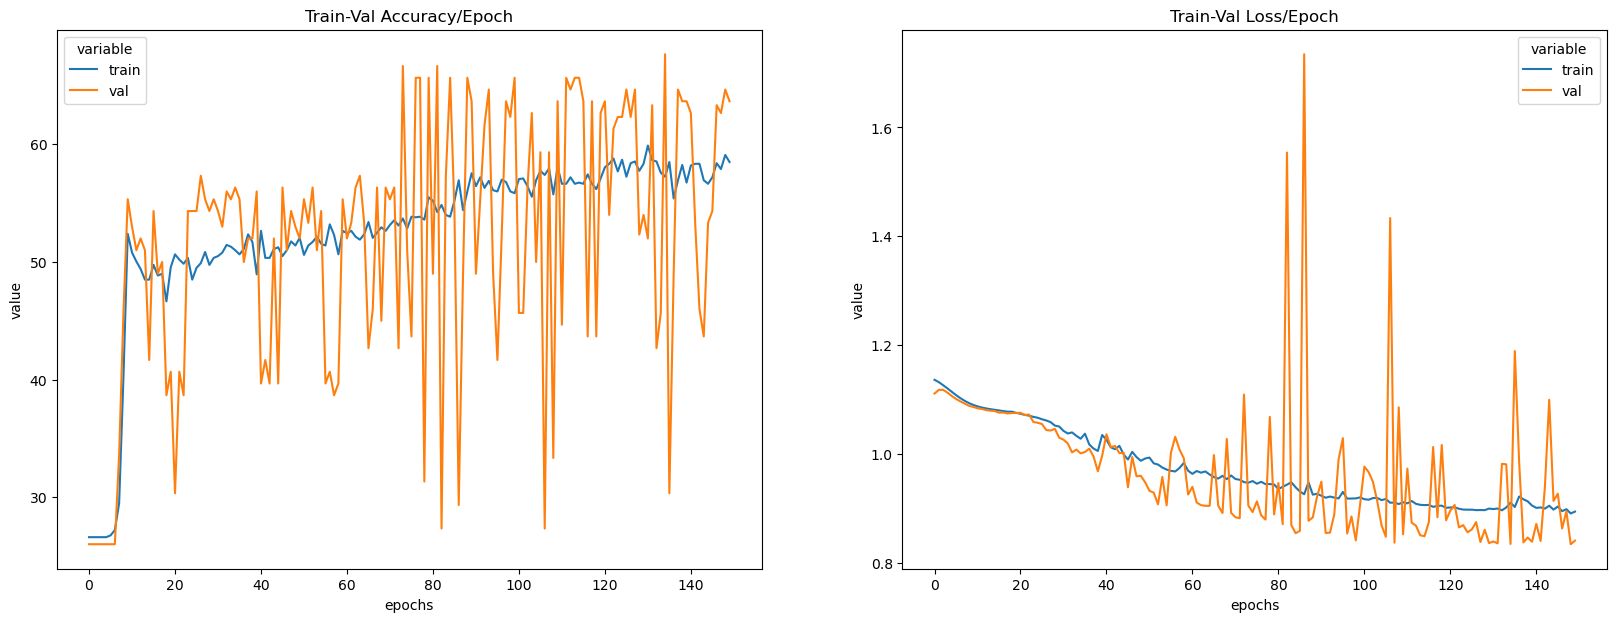

In [60]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [36]:
print("model = ", model)
print("optimizer = ", optimizer)
print("start_epoch = ", start_epoch)
print("valid_acc_max = ", valid_acc_max)
print("valid_acc_max = {:.6f}".format(valid_acc_max))

model =  InceptionModel(
  (blocks): Sequential(
    (0): InceptionBlock(
      (bottleneck): Conv1dSamePadding(1, 2, kernel_size=(1,), stride=(1,), bias=False)
      (conv_layers): Sequential(
        (0): Conv1dSamePadding(2, 32, kernel_size=(5,), stride=(1,), bias=False)
        (1): Conv1dSamePadding(32, 32, kernel_size=(2,), stride=(1,), bias=False)
        (2): Conv1dSamePadding(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
      (max_pool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (residual): Sequential(
        (0): Conv1dSamePadding(1, 32, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): InceptionBlock(
      (bottleneck): Conv1dSamePadding(32, 2, kernel_size=(1,), stride=(1,), b

# Now running the projection algorithm 

In [37]:
X_train.shape, y_train.shape, X_val.shape,y_val.shape

((612, 1, 28), (612,), (68, 1, 28), (68,))

In [37]:
X_merge_big=X

In [64]:
X_merge_small=samp_X

In [38]:
Y_merge_big=np.concatenate((y_train, Y_val_pred,y_test),axis=0)


In [65]:
Y_merge_small=np.concatenate((y_train, Y_val_pred,y_test),axis=0)

In [66]:
Y_merge_big.shape, Y_merge_small.shape

((1186,), (850,))

In [14]:
Y_merge_big=np.load("./Y_merge_big.npy")
Y_merge_small=np.load("./Y_merge_small.npy")

In [15]:
import numpy as np
# even if I set the seed here the other cells don't see it
np.random.seed(333)

In [16]:

n_eig_vecs=850
orth_x=orthonormal_space(X,n_eig_vecs=850)
P=orth_x.T


In [17]:
y_small=torch.tensor(Y_merge_small, dtype=torch.float32).view(-1, 1)

In [18]:
y=torch.tensor(Y_merge_big, dtype=torch.float32).view(-1,1)

In [21]:
model= VariationalLinearModel(850,1186)

In [22]:
loss_list,predicted_y_list=train_model(P, y, model, learning_rate=0.01, epochs= 500 )

Epoch [10/500], KL Loss: 1.9759
Epoch [20/500], KL Loss: 1.6631
Epoch [30/500], KL Loss: 1.5265
Epoch [40/500], KL Loss: 1.2123
Epoch [50/500], KL Loss: 0.9122
Epoch [60/500], KL Loss: 0.6936
Epoch [70/500], KL Loss: 0.6903
Epoch [80/500], KL Loss: 0.5408
Epoch [90/500], KL Loss: 0.4186
Epoch [100/500], KL Loss: 0.3441
Epoch [110/500], KL Loss: 0.2731
Epoch [120/500], KL Loss: 0.2399
Epoch [130/500], KL Loss: 0.1753
Epoch [140/500], KL Loss: 0.1308
Epoch [150/500], KL Loss: 0.1308
Epoch [160/500], KL Loss: 0.0929
Epoch [170/500], KL Loss: 0.1383
Epoch [180/500], KL Loss: 0.0468
Epoch [190/500], KL Loss: 0.0561
Epoch [200/500], KL Loss: 0.0524
Epoch [210/500], KL Loss: 0.0300
Epoch [220/500], KL Loss: 0.0217
Epoch [230/500], KL Loss: 0.0538
Epoch [240/500], KL Loss: 0.0160
Epoch [250/500], KL Loss: 0.0486
Epoch [260/500], KL Loss: 0.0404
Epoch [270/500], KL Loss: 0.0415
Epoch [280/500], KL Loss: 0.0340
Epoch [290/500], KL Loss: 0.0012
Epoch [300/500], KL Loss: 0.0020
Epoch [310/500], KL

In [ ]:
predicted_y_list

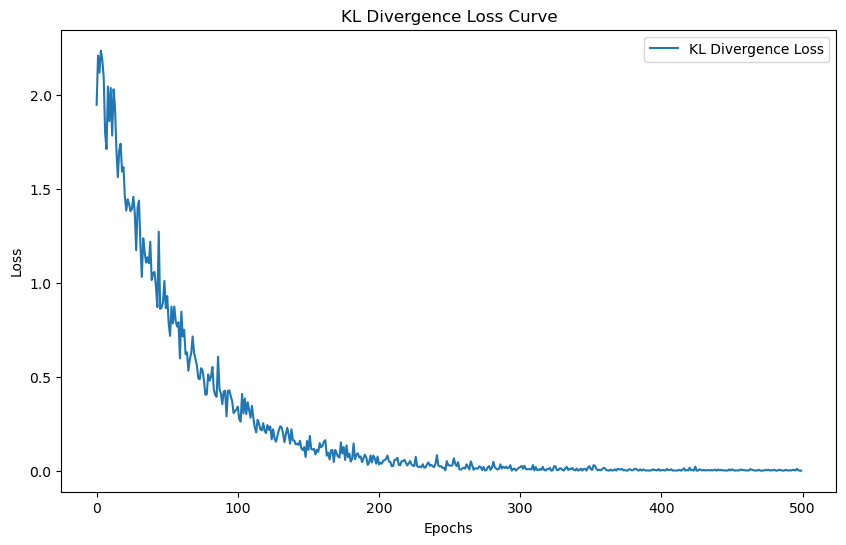

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(loss_list, label='KL Divergence Loss')
plt.title('KL Divergence Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
model2=Re_VAE_LinearModel(850,1186)

In [24]:
loss_list_2, y_beta_pred=train_model(P, y, model2, learning_rate=0.01, epochs= 500 )

Epoch [10/500], KL Loss: 1.3432
Epoch [20/500], KL Loss: 1.0626
Epoch [30/500], KL Loss: 0.9945
Epoch [40/500], KL Loss: 0.7560
Epoch [50/500], KL Loss: 0.5267
Epoch [60/500], KL Loss: 0.5604
Epoch [70/500], KL Loss: 0.3680
Epoch [80/500], KL Loss: 0.3814
Epoch [90/500], KL Loss: 0.2173
Epoch [100/500], KL Loss: 0.1957
Epoch [110/500], KL Loss: 0.1706
Epoch [120/500], KL Loss: 0.0905
Epoch [130/500], KL Loss: 0.1131
Epoch [140/500], KL Loss: 0.0868
Epoch [150/500], KL Loss: 0.0765
Epoch [160/500], KL Loss: 0.0786
Epoch [170/500], KL Loss: 0.0525
Epoch [180/500], KL Loss: 0.0329
Epoch [190/500], KL Loss: 0.0132
Epoch [200/500], KL Loss: 0.0034
Epoch [210/500], KL Loss: 0.0157
Epoch [220/500], KL Loss: 0.0053
Epoch [230/500], KL Loss: 0.0182
Epoch [240/500], KL Loss: 0.0024
Epoch [250/500], KL Loss: 0.0043
Epoch [260/500], KL Loss: 0.0045
Epoch [270/500], KL Loss: 0.0036
Epoch [280/500], KL Loss: 0.0003
Epoch [290/500], KL Loss: 0.0060
Epoch [300/500], KL Loss: 0.0010
Epoch [310/500], KL

In [27]:
type(y_beta_pred)

list

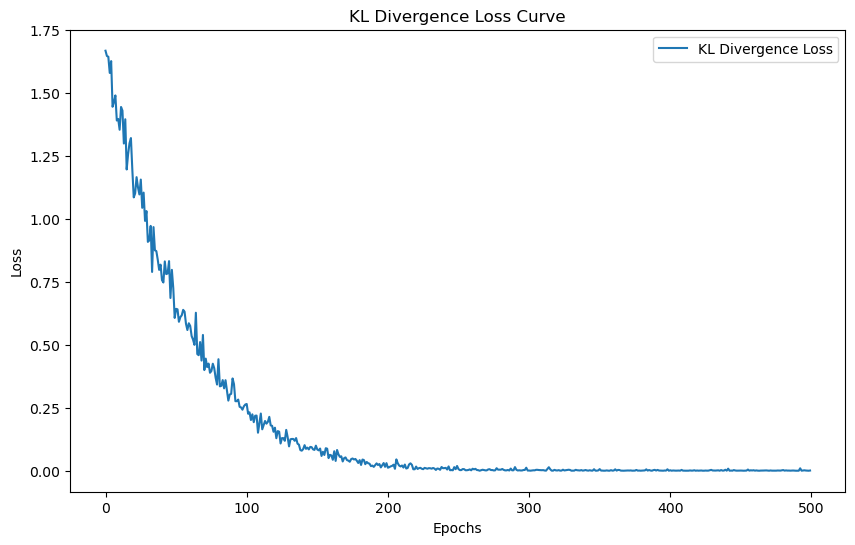

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(loss_list_2, label='KL Divergence Loss')
plt.title('KL Divergence Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

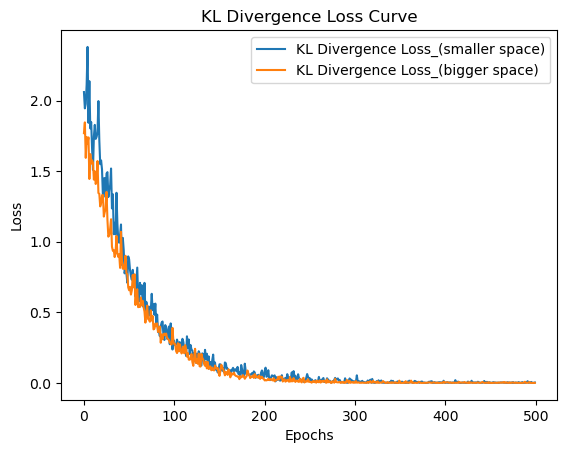

In [52]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(loss_list, label='KL Divergence Loss_(smaller space)')
ax1.plot(loss_list_2, label='KL Divergence Loss_(bigger space)')
plt.title('KL Divergence Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
len(loss_list)

500

In [37]:
len(loss_list_2)

500

In [91]:
#common_elements = list(set(loss_list) & set(loss_list_2))

In [93]:
#common_elements.sort()

#top_2_minimum = common_elements[:2]

In [25]:
min_val=min(loss_list)
loss_list.index(min_val)

412

In [26]:
predicted_y_list[412]

tensor([[ 2.3807],
        [-0.0478],
        [ 0.3479],
        [-0.6614],
        [ 2.1199],
        [-0.5558],
        [ 1.2240],
        [ 0.5182],
        [ 1.1888],
        [-1.2542],
        [ 1.1776],
        [ 0.2271],
        [ 0.5672],
        [-0.2346],
        [-0.5699],
        [ 0.1150],
        [ 1.6543],
        [-0.0636],
        [ 0.5086],
        [ 2.7698],
        [ 0.8736],
        [ 0.9825],
        [ 2.7729],
        [ 0.1485],
        [ 0.3443],
        [ 1.0229],
        [ 1.1803],
        [ 0.6129],
        [ 1.3753],
        [ 1.5018],
        [-0.1630],
        [ 0.4057],
        [-0.2624],
        [ 0.7437],
        [ 0.7698],
        [ 0.0163],
        [-0.1206],
        [ 0.8228],
        [ 1.3600],
        [ 1.1957],
        [-0.0172],
        [ 0.6680],
        [ 0.1767],
        [ 1.3165],
        [ 1.5019],
        [ 0.3856],
        [ 1.2173],
        [ 0.9859],
        [ 1.5285],
        [ 0.8660],
        [ 1.1889],
        [ 1.2985],
        [-0.

In [27]:
mean2=predicted_y_list[412].mean()
std_dev2=predicted_y_list[412].std()

In [28]:
mean1=y_small.mean()
std_dev1=y_small.std()

In [29]:
array1=predicted_y_list[412]
array2=y_small.numpy()

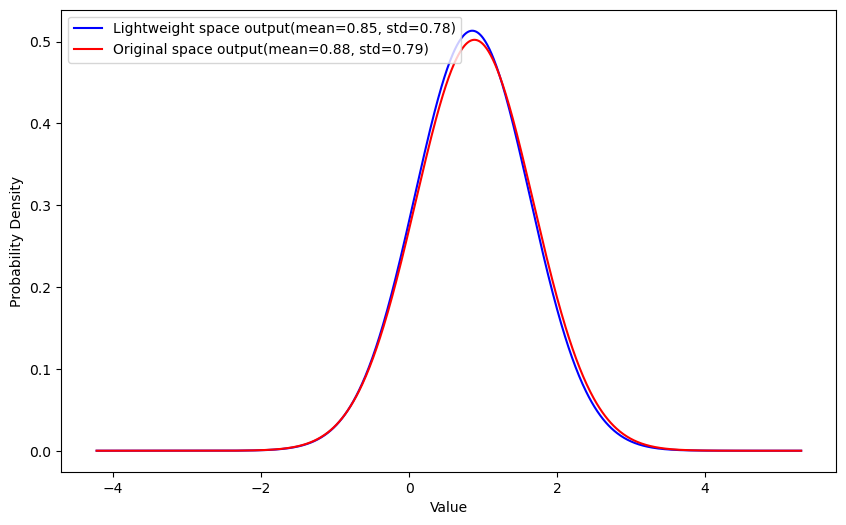

In [31]:
from scipy.stats import norm 

# Generate x values
x = np.linspace(min(array1.min(), array2.min()), max(array1.max(), array2.max()), 1000)

# Calculate the PDF for each array
pdf1 = norm.pdf(x, mean1, std_dev1)
pdf2 = norm.pdf(x, mean2, std_dev2)

# Plot the PDFs
plt.figure(figsize=(10, 6))
plt.plot(x, pdf1, label=f'Lightweight space output(mean={mean1:.2f}, std={std_dev1:.2f})', color='blue')
plt.plot(x, pdf2, label=f'Original space output(mean={mean2:.2f}, std={std_dev2:.2f})', color='red')

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

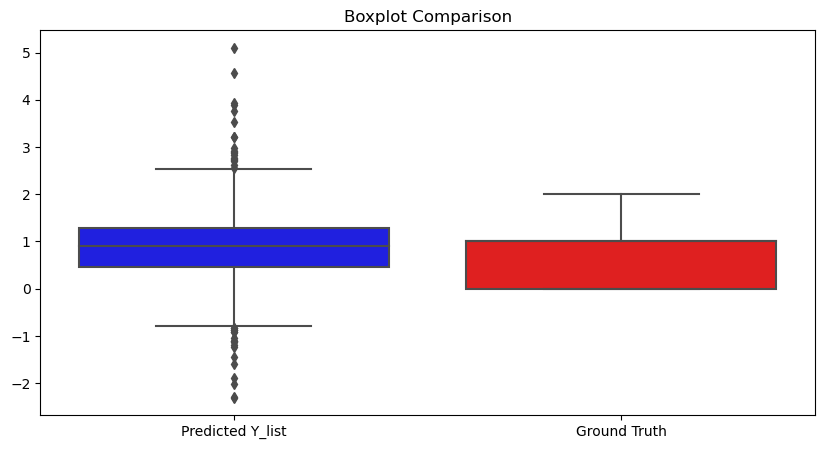

In [55]:
#box plot comparision
import seaborn as sns
# Boxplot comparison
plt.figure(figsize=(10, 5))
sns.boxplot(data=[array1, array2], palette=["blue", "red"])
plt.xticks([0, 1], ['Predicted Y_list', 'Ground Truth'])
plt.title('Boxplot Comparison')
plt.show()



In [47]:
min(loss_list)

4.4656917452812195e-06

In [48]:
min(loss_list_2)

3.204098902642727e-06

In [57]:
mean_of_alpha_dist= predicted_y_list[475].mean()
std_of_apha_dist=predicted_y_list[475].std()

In [58]:
mean_of_alpha_dist,std_of_apha_dist

(tensor(0.8751), tensor(0.7932))

In [59]:
mean_of_small_gr=Y_merge_small.mean()
std_of_small_gr=Y_merge_small.std()

mean_of_small_gr, std_of_small_gr

(0.8529411764705882, 0.7765819884436456)

In [60]:
mean_of_big_gr=Y_merge_big.mean()
std_of_big_gr=Y_merge_big.std()

mean_of_big_gr, std_of_small_gr

(0.8760539629005059, 0.7765819884436456)

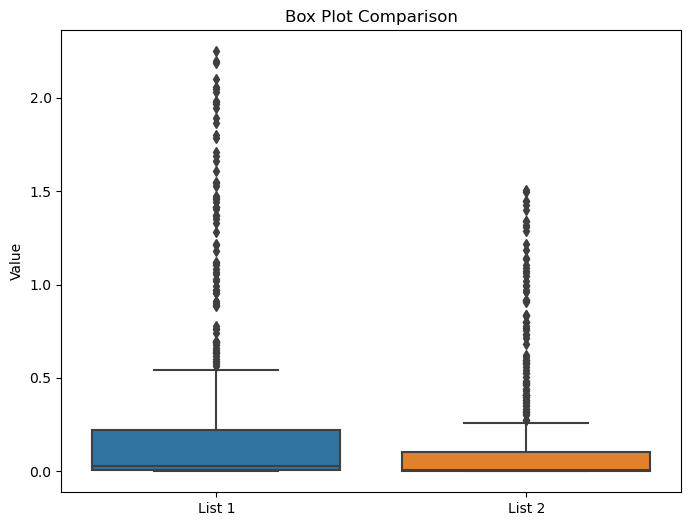

In [33]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(data=[loss_list, loss_list_2])
plt.title('Box Plot Comparison')
plt.xticks([0, 1], ['List 1', 'List 2'])
plt.ylabel('Value')
plt.show()


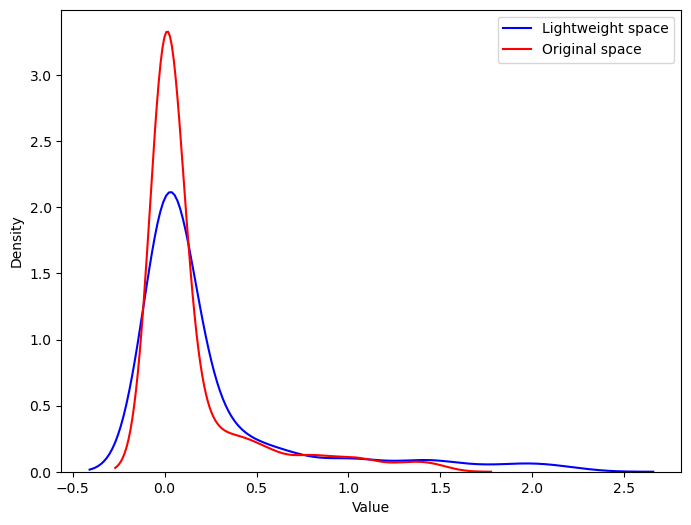

In [35]:
plt.figure(figsize=(8, 6))
sns.kdeplot(loss_list, label='Lightweight space', color='blue')
sns.kdeplot(loss_list_2, label='Original space', color='red')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

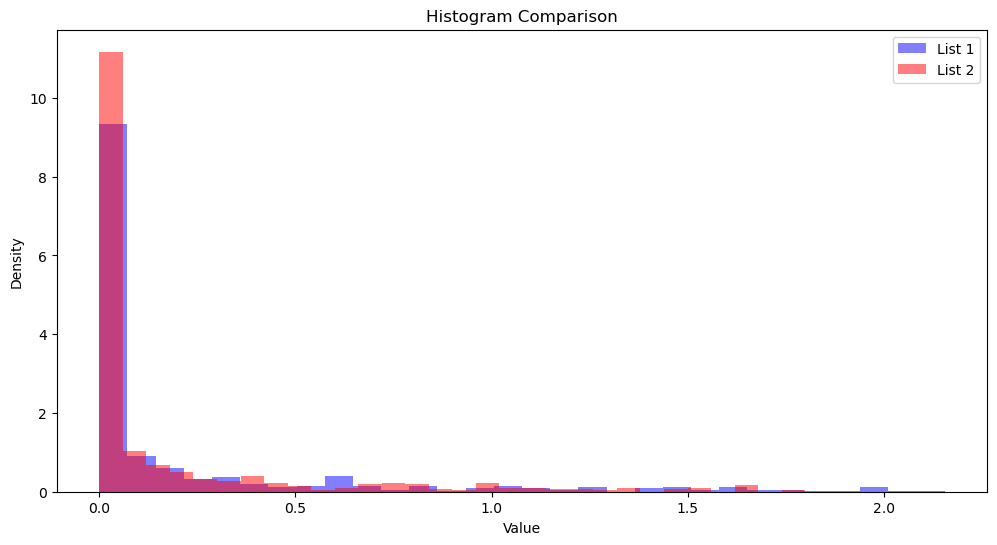

In [102]:
plt.figure(figsize=(12, 6))
plt.hist(loss_list, bins=30, alpha=0.5, label='List 1', color='blue', density=True)
plt.hist(loss_list_2, bins=30, alpha=0.5, label='List 2', color='red', density=True)
plt.title('Histogram Comparison')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [63]:
rounded=np.round(predicted_y_list[475].numpy())

In [64]:
abs_rounded=np.abs(rounded)

In [65]:
from collections import Counter
value_counts = Counter(abs_rounded.flatten())

# Displaying the counts of each unique value
for value, count in value_counts.items():
    print(f"Value: {value}, Count: {count}")

Value: 3.0, Count: 16
Value: 1.0, Count: 508
Value: 0.0, Count: 194
Value: 2.0, Count: 126
Value: 5.0, Count: 2
Value: 4.0, Count: 4


In [66]:
matches=np.equal(abs_rounded,y_small.numpy())
accuracy = np.sum(matches) / matches.size

In [67]:
accuracy

0.3211764705882353

In [68]:
def bhattacharyya(P, Q):
    return -np.log(np.sum(np.sqrt(P * Q)))


# Bhattacharyya Distance
b_distance = bhattacharyya(abs_rounded,y_small.numpy())
print(f"Bhattacharyya Distance: {b_distance}")

Bhattacharyya Distance: -6.236084938049316


In [117]:
# Explainability, 
f_hat_i=np.mean(X, axis=0)
f_hat_i.shape

(28,)

In [104]:
Y_merge_big[:,np.newaxis].shape

(1186, 1)

In [105]:
# for big 
y_prime_hat_big=np.mean(Y_merge_big)
y_prime_big=Y_merge_big[:,np.newaxis]
avg_big=(f_hat_i + y_prime_hat_big)/ 2
n_prime_big=X.shape[0]

# Calculating the score

numerator = n_prime_big * ((f_hat_i - avg_big)**2 + (y_prime_hat_big - avg_big)**2)

sum_f_term = np.sum((X[:, :] - avg_big )**2, axis=0)
sum_y_prime_term = np.sum((y_prime_big - avg_big[np.newaxis, :])**2, axis=0)
score=numerator/(sum_f_term + sum_y_prime_term)

In [118]:
y_prime_hat=np.mean(predicted_y_list[475].numpy())
y_prime_hat

0.87505966

In [119]:
y_prime=predicted_y_list[475]
y_prime.shape

torch.Size([850, 1])

In [120]:
avg=(f_hat_i + y_prime_hat)/ 2
avg.shape

(28,)

In [121]:
n_prime=samp_X.shape[0]

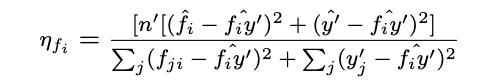

In [122]:
# Calculating the score

numerator = n_prime * ((f_hat_i - avg)**2 + (y_prime_hat - avg)**2)

sum_f_term = np.sum((X[:, :] - avg )**2, axis=0)
sum_y_prime_term = np.sum((y_prime.numpy() - avg[np.newaxis, :])**2, axis=0)
score=numerator/(sum_f_term + sum_y_prime_term)

In [123]:
score.shape

(28,)

In [124]:
values=score.tolist()

In [125]:
values

[0.7980262436232382,
 0.05496868676846744,
 0.2780789851590515,
 0.009402229751425155,
 0.25073156423791815,
 0.24466307887344904,
 0.055224220156644827,
 0.28047258925541785,
 0.010154118475286,
 0.24818148866843365,
 0.24133803026759346,
 0.05428523806570446,
 0.28023063230268347,
 0.008877983833270316,
 0.2494955647135385,
 0.24478902291568022,
 0.05563919755999429,
 0.2796304951237928,
 0.009629113494386318,
 0.2503483184662645,
 0.24366741151517954,
 0.053885414519553754,
 0.2749305388999483,
 0.00682439531681721,
 0.24958612454839557,
 0.24023273649941213,
 0.34769214221015865,
 0.35220858490804485]

In [126]:
features=df.columns.tolist()[:-1]

In [127]:
features

['age',
 'A_mean_corr',
 'A_gev',
 'A_occurrences',
 'A_timecov',
 'A_meandurs',
 'B_mean_corr',
 'B_gev',
 'B_occurrences',
 'B_timecov',
 'B_meandurs',
 'C_mean_corr',
 'C_gev',
 'C_occurrences',
 'C_timecov',
 'C_meandurs',
 'D_mean_corr',
 'D_gev',
 'D_occurrences',
 'D_timecov',
 'D_meandurs',
 'F_mean_corr',
 'F_gev',
 'F_occurrences',
 'F_timecov',
 'F_meandurs',
 'unlabeled',
 'gfp_value']

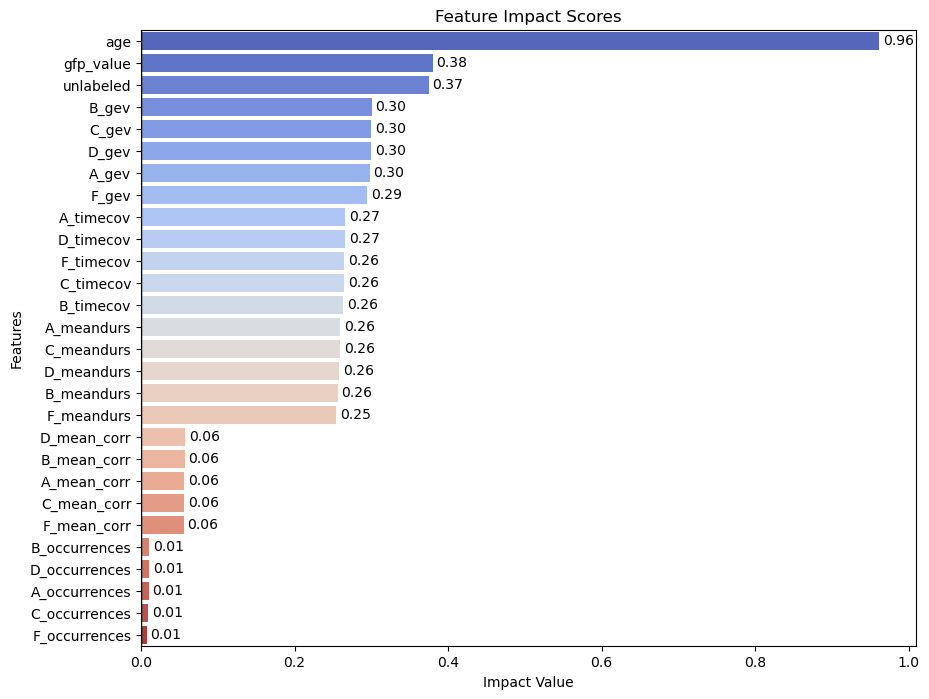

In [116]:
# Sort the values and features together for better visualization
sorted_indices = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
sorted_values = [values[i] for i in sorted_indices]
sorted_features = [features[i] for i in sorted_indices]

plt.figure(figsize=(10, 8))

ax=sns.barplot(x=sorted_values, y=sorted_features, palette='coolwarm', orient='h')


# Add the values on top of each bar
for i, v in enumerate(sorted_values):
    ax.text(v + 0.005, i, f'{v:.2f}', color='black', va='center')

# Add a vertical line at x=0 for reference
plt.axvline(x=0, color='black', linewidth=1)

# Add titles and labels
plt.title('Feature Impact Scores')
plt.xlabel('Impact Value')
plt.ylabel('Features')

plt.show()

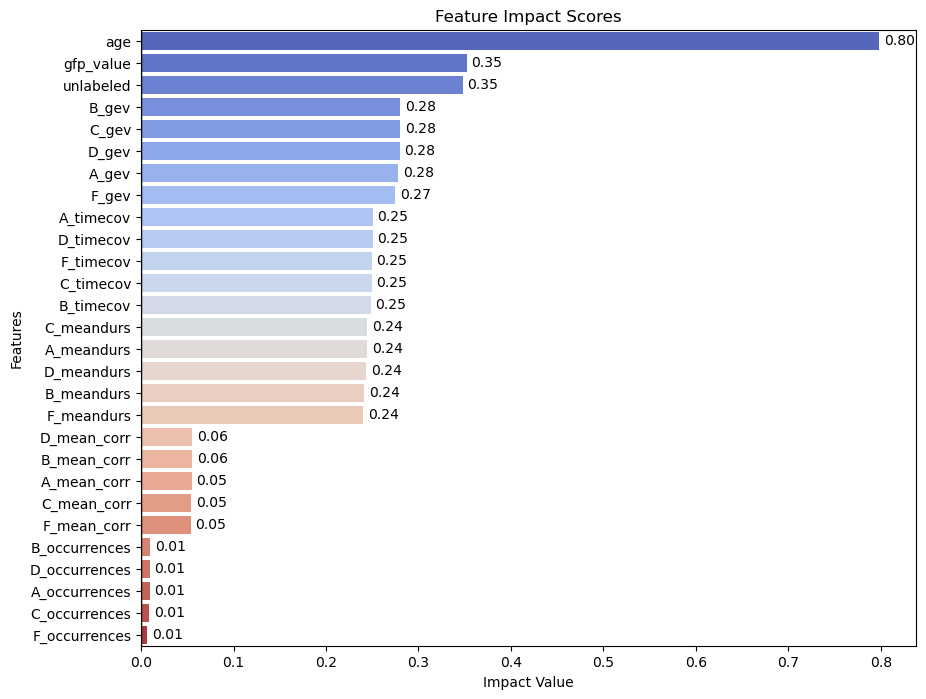

In [128]:
# Sort the values and features together for better visualization
sorted_indices = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
sorted_values = [values[i] for i in sorted_indices]
sorted_features = [features[i] for i in sorted_indices]

plt.figure(figsize=(10, 8))

ax=sns.barplot(x=sorted_values, y=sorted_features, palette='coolwarm', orient='h')

# Add the values on top of each bar
for i, v in enumerate(sorted_values):
    ax.text(v + 0.005, i, f'{v:.2f}', color='black', va='center')

# Add a vertical line at x=0 for reference
plt.axvline(x=0, color='black', linewidth=1)

# Add titles and labels
plt.title('Feature Impact Scores')
plt.xlabel('Impact Value')
plt.ylabel('Features')

plt.show()

